# Sentiment classification of TV reviews using ReLU  
Sentiment analysis of "[Tatort](https://en.wikipedia.org/wiki/Tatort)" Reviews.  
Data source: Facebook comments pulled from weekly 'poll' postings on the 'dasErste' FB page.

1 = positive review  
2 = negative review

## Import and review the data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
import matplotlib.pyplot as plt

tatortreviews = pd.read_csv('data/tatort_reviews_labeled.csv')
print("Number of reviews: ", len(tatortreviews))

tatortreviews.head()

Number of reviews:  2000


,Review,Evalu
0,schlechteste ever 😣,0
1,6 absolut kein thema mehr,0
2,"ein sehr guter tatort (y), das franken-team so...",1
3,absolute 6!,0
4,"kann nicht mitreden. ""x-men: apocalypse"" auf s...",0


In [2]:
reviews = tatortreviews['Review']
labels = tatortreviews['Evalu']

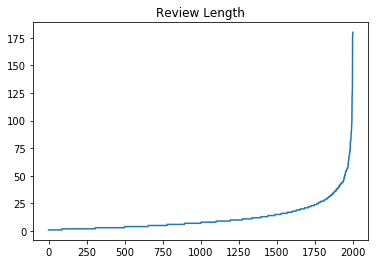

In [10]:
%matplotlib inline

review_lengths = []
for review in reviews:
    review_lengths.append(len(review.split(' ')))
plt.figure()
plt.title('Review Length')
plt.plot(sorted(review_lengths))

#### Bag of Words

In [11]:
from collections import Counter

total_wordcount = Counter()

for row in reviews:
    total_wordcount.update(row.split(" "))
    
print("Total word count: ", len(total_wordcount))

Total word count:  6016


In [12]:
vocabulary = sorted(total_wordcount, key=total_wordcount.get, reverse=True)[:6010]
vocabulary = vocabulary[10:]
    
print("Num of words: ", len(vocabulary))
for x in range(0, 10):
    print(vocabulary[x])

Num of words:  6000
mal
gut
eine
den
es
aber
zu
wieder
1
mit


In [13]:
wordindex = {word: i for i, word in enumerate(vocabulary)}

print(wordindex.get('spannend'))
print(wordindex.get('doof'))

35
1442


## Mapping text to vector

In [14]:
def text_to_vector(text):
    word_vector = np.zeros(len(vocabulary), dtype = np.int_)
    for word in text.split(' '):
        idx = wordindex.get(word, None)
        if idx is None:
            continue
        else:
            word_vector[idx] += 1
    return np.array(word_vector)
 
word_vectors = np.zeros((len(reviews), len(vocabulary)), dtype=np.int_)    
for ii, text in enumerate(reviews):
    word_vectors[ii] = text_to_vector(text)

### Split data into Train, Validation, Test sets

In [15]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(reviews, labels, test_size=0.1, random_state=666)

#print(len(X_train))
#print(len(Y_train))

Y = labels
records = len(labels)

shuffle = np.arange(records)
np.random.shuffle(shuffle)
test_fraction = 0.9

train_split, test_split = shuffle[:int(records*test_fraction)], shuffle[int(records*test_fraction):]
X_train, Y_train = word_vectors[train_split], to_categorical(Y.values[train_split], 2)
X_test, Y_test = word_vectors[test_split], to_categorical(Y.values[test_split], 2)

## Building the network

In [16]:
def build_network_model():
    tf.reset_default_graph()
    
    #Inputs
    net = tflearn.input_data([None, 6000])
    
    #Hidden layer
    net = tflearn.fully_connected(net, 120, activation='relu')
    
    #Output Layer
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='sgd', learning_rate=0.09, loss='categorical_crossentropy')
    
    model = tflearn.DNN(net)
    return model


# Now, build it!
model = build_network_model()

## Training the network


In [ ]:
model.fit(X_train, Y_train, validation_set = 0.1, show_metric=True, batch_size=300, n_epoch=100)

Training Step: 185  | total loss: 0.62902 | time: 0.092s
| SGD | epoch: 031 | loss: 0.62902 - acc: 0.6240 -- iter: 1500/1620


## Testing 

In [331]:
predictions = (np.array(model.predict(X_test)) >= 0.5).astype(np.int_)
test_accuracy = np.mean(predictions == Y_test, axis=0)
print("Test accuracy: ", test_accuracy)

Test accuracy:  [ 0.855  0.855]


In [320]:
# Check with a custom sentence.
# res = the result of the prediction, containing the positive and negative probability.
res = model.predict([text_to_vector("ein spannender film")])[0]
print(res)
if(res[1] > res[0]):
    print('Positiv!')
else:
    print('Negativ!')

[0.18156996369361877, 0.8184300065040588]
Positiv!
